In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rfgap import RFGAP
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from rfoversample import RFOversampler

import sys
sys.path.append("SupportFunctions")

from prepare_datasets import DatasetPreprocessor  
from imbalancer import ImbalanceHandler

In [10]:
titanic = pd.read_csv('./datasets/titanic.csv')
titanic_cat_cols = ['Pclass', 'Sex', 'Embarked']

COMPARE F1 SCORES

In [11]:
#encode titanic dataset's categorical features, use preprocessor (built off sklearn train-test split) to split the dataset
encoded_titanic = pd.get_dummies(titanic, columns=titanic_cat_cols, dtype=int)
preprocessor = DatasetPreprocessor(encoded_titanic, target_column='Survived')
x_train, y_train, x_test, y_test = (preprocessor.x_train, preprocessor.y_train,
                                    preprocessor.x_test, preprocessor.y_test)



#Introduce a 10:1 imbalance ratio to the training dataset
Imbalancer = ImbalanceHandler(x_train, y_train, imbalance_ratio=0.1) 
x_train_imbal, y_train_imbal = Imbalancer.introduce_imbalance()

#Oversample the imbalanced training dataset using the RFOversampler
# TrainData_imbal = pd.concat((y_train_imbal, x_train_imbal), axis=1)
TitanicOversampler = RFOversampler(x_train=x_train_imbal, y_train=y_train_imbal, contains_categoricals=True, encoded=True, cat_cols=titanic_cat_cols)
RF_upsampled_x_train, RF_upsampled_y_train = TitanicOversampler.fit()

Original class distribution: {0: 302, 1: 196}
Imbalanced class distribution: {0: 80, 1: 20}


In [12]:
#Upsample imbalanced training dataset using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
SM_upsampled_x_train, SM_upsampled_y_train = smote.fit_resample(x_train_imbal, y_train_imbal)

In [13]:
def Compare_RF_F1scores(n, OG_x_train, OG_y_train, RF_x_train_upsampled, RF_y_train_upsampled, SM_x_train_upsampled, SM_y_train_upsampled, x_test, y_test):

    scores_OG = np.zeros(n)
    scores_RF_upsampled = np.zeros(n)
    scores_SM_upsampled = np.zeros(n)

    for i in range(n):

        #train, fit, and predict original points
        original_RF = RandomForestClassifier(class_weight='balanced')
        original_RF.fit(OG_x_train, OG_y_train)
        y_pred_original = original_RF.predict(x_test)

        #train, fit, and predict points upsampled by Random Forest Upsampler
        RF_upsampled_RF = RandomForestClassifier()
        RF_upsampled_RF.fit(RF_x_train_upsampled, RF_y_train_upsampled)
        y_pred_RF_upsampled = RF_upsampled_RF.predict(x_test)

        #train, fit, and predict points upsampled by SMOTE
        SM_upsampled_RF = RandomForestClassifier()
        SM_upsampled_RF.fit(SM_x_train_upsampled, SM_y_train_upsampled)
        y_pred_SM_upsampled = SM_upsampled_RF.predict(x_test)
    
        #append f1 scores
        scores_OG[i] = f1_score(y_test, y_pred_original, average='binary')
        scores_RF_upsampled[i] = f1_score(y_test, y_pred_RF_upsampled, average='binary')
        scores_SM_upsampled[i] = f1_score(y_test, y_pred_SM_upsampled, average='binary')

    return scores_OG, scores_RF_upsampled, scores_SM_upsampled

    

In [14]:
#F1 scores for the original, RF upsampled, and SMOTE upsampled datasets (from Random Forest Classifier)
scores_OG, scores_RF_upsampled, scores_SM_upsampled = Compare_RF_F1scores(20, x_train_imbal, y_train_imbal,
                                                                          RF_upsampled_x_train, RF_upsampled_y_train,
                                                                          SM_upsampled_x_train, SM_upsampled_y_train,
                                                                          x_test, y_test)

Text(0.5, 0.98, 'F1 Scores From RandomForestClassifier (0.1 imbalance ratio)')

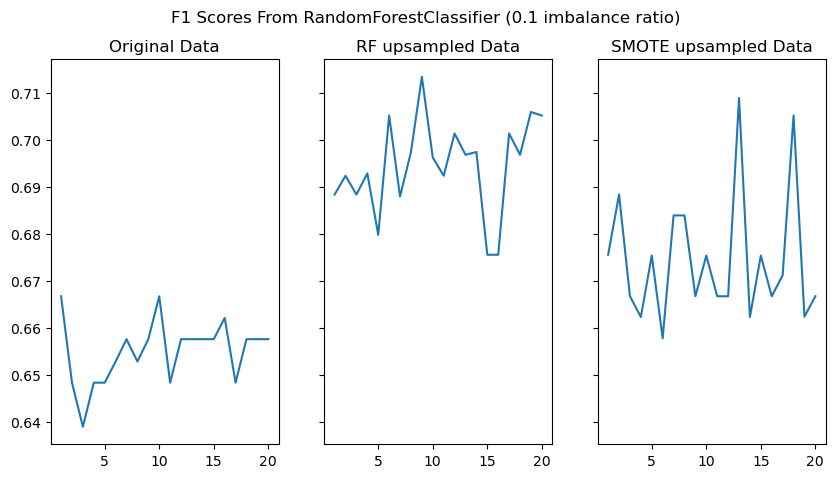

In [15]:
fig, ax = plt.subplots(1,3, figsize=(10,5), sharey=True)

ax[0].plot(range(1,21), scores_OG)
ax[0].set(title='Original Data')
ax[1].plot(range(1,21), scores_RF_upsampled)
ax[1].set(title='RF upsampled Data')
ax[2].plot(range(1,21), scores_SM_upsampled)
ax[2].set(title='SMOTE upsampled Data')
fig.suptitle('F1 Scores From RandomForestClassifier (0.1 imbalance ratio)')

In [16]:
def Compare_LR_F1scores(OG_x_train, OG_y_train, RF_x_train_upsampled, RF_y_train_upsampled, SM_x_train_upsampled, SM_y_train_upsampled, x_test, y_test):

    score_OG = None
    score_RF_upsampled = None
    score_SM_upsampled = None

    #train, fit, and predict original points
    original_LR = LogisticRegression(class_weight='balanced')
    original_LR.fit(OG_x_train, OG_y_train)
    y_pred_original = original_LR.predict(x_test)

    #train, fit, and predict points upsampled by Random Forest Upsampler
    RF_upsampled_LR = LogisticRegression()
    RF_upsampled_LR.fit(RF_x_train_upsampled, RF_y_train_upsampled)
    y_pred_RF_upsampled = RF_upsampled_LR.predict(x_test)

    #train, fit, and predict points upsampled by SMOTE
    SM_upsampled_LR = LogisticRegression()
    SM_upsampled_LR.fit(SM_x_train_upsampled, SM_y_train_upsampled)
    y_pred_SM_upsampled = SM_upsampled_LR.predict(x_test)

    #append f1 scores
    score_OG = f1_score(y_test, y_pred_original, average='binary')
    score_RF_upsampled = f1_score(y_test, y_pred_RF_upsampled, average='binary')
    score_SM_upsampled = f1_score(y_test, y_pred_SM_upsampled, average='binary')

    return score_OG, score_RF_upsampled, score_SM_upsampled

In [17]:
#F1 scores for the original, RF upsampled, and SMOTE upsampled datasets (from Logistic Regression)
score_OG_LogisticR, score_RF_upsampled_LogisticR, score_SM_upsampled_LogisticR = Compare_LR_F1scores(x_train_imbal, y_train_imbal,
                                                                          RF_upsampled_x_train, RF_upsampled_y_train,
                                                                          SM_upsampled_x_train, SM_upsampled_y_train,
                                                                          x_test, y_test)

c:\Users\potat\miniconda3\envs\MachineLearning\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\potat\miniconda3\envs\MachineLearning\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Text(0.5, 1.0, 'F1 Scores From Logistic Regression (0.1 imbalance ratio)')

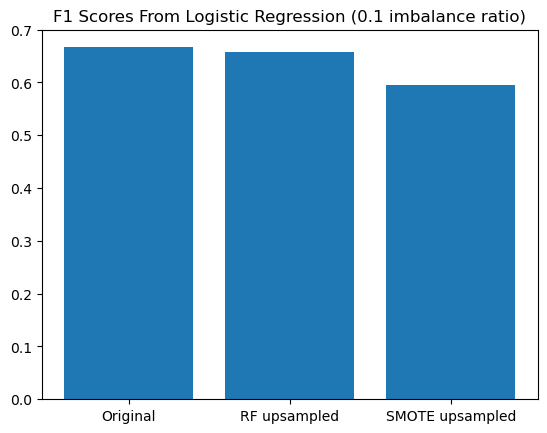

In [18]:
plt.bar(x=['Original', 'RF upsampled', 'SMOTE upsampled'], height=[score_OG_LogisticR, score_RF_upsampled_LogisticR, score_SM_upsampled_LogisticR])
plt.title('F1 Scores From Logistic Regression (0.1 imbalance ratio)')

In [19]:
##testing if algorithm works on dataset treating all features as numeric
preprocessor2 = DatasetPreprocessor(titanic, target_column='Survived')
x_train2, y_train2, x_test2, y_test2 = (preprocessor2.x_train, preprocessor2.y_train,
                                    preprocessor2.x_test, preprocessor2.y_test)
TitanicOversampler2 = RFOversampler(x_train=x_train2, y_train=y_train2, contains_categoricals=False, encoded=False, cat_cols=None)
RF_upsampled_x_train2, RF_upsampled_y_train2 = TitanicOversampler2.fit()
RF_upsampled_x_train2

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,2.000000,0.000000,5.000000,1.000000,2.000000,27.750000,2.000000
1,3.000000,1.000000,28.500000,0.000000,0.000000,7.229200,0.000000
2,1.000000,1.000000,71.000000,0.000000,0.000000,34.654200,0.000000
3,3.000000,1.000000,24.000000,0.000000,0.000000,7.050000,2.000000
4,3.000000,1.000000,32.000000,0.000000,0.000000,7.854200,2.000000
...,...,...,...,...,...,...,...
599,2.666667,0.666667,19.333333,0.666667,0.666667,10.922200,2.000000
600,2.333333,0.000000,21.333333,1.333333,0.666667,92.868067,1.666667
601,2.666667,0.333333,35.000000,0.000000,0.000000,8.801400,2.000000
602,1.000000,0.666667,34.000000,0.000000,0.000000,45.277767,1.333333


In [20]:
RF_upsampled_RF = RandomForestClassifier()
RF_upsampled_RF.fit(RF_upsampled_x_train2, RF_upsampled_y_train2)
y_pred_RF_upsampled = RF_upsampled_RF.predict(x_test2)
f1_score(y_test2, y_pred_RF_upsampled, average='binary')

0.7085714285714285